In [3]:
import pandas as pd
import os
from concurrent.futures import ProcessPoolExecutor

def load_data(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                header_line = line[1:].strip()
                columns = header_line.split('\t')
                break
        else:
            raise ValueError(f"No header line found in {file_path}")
    
    df = pd.read_csv(file_path, sep='\t', header=None, names=columns, comment='#')
    
    if 'Me' not in df.columns or 'Un' not in df.columns:
        raise ValueError(f("'Me' or 'Un' columns not found in {file_path}"))

    df['meth'] = df['Me'] / (df['Me'] + df['Un'])
    df = df[(df['meth'] > 0) & (df['meth'] < 1)]
    
    return df

def process_single_file(file_path):
    processed_data = load_data(file_path)
    
    if "CHG" in file_path:
        return 'CHG', processed_data
    elif "CpG" in file_path:
        return 'CpG', processed_data
    elif "CHH" in file_path:
        return 'CHH', processed_data
    else:
        return 'Unknown', processed_data  

def process_files(directory):
    data_dict = {'CHG': [], 'CpG': [], 'CHH': []}
    
    dir_path = os.path.join(base_path, directory)
    
    if not os.path.isdir(dir_path):
        print(f"Directory {dir_path} does not exist. Skipping.")
        return data_dict
    
    file_paths = [os.path.join(dir_path, file_name) 
                  for file_name in os.listdir(dir_path) if file_name.endswith('.txt')]
    
    with ProcessPoolExecutor(max_workers=12) as executor:  
        results = executor.map(process_single_file, file_paths)
    
    for category, processed_data in results:
        if category in data_dict:
            data_dict[category].append(processed_data)
        else:
            print(f"Unknown category '{category}' in file {file_path}. Skipping.")
    
    for key in data_dict:
        if data_dict[key]:  
            data_dict[key] = pd.concat(data_dict[key], ignore_index=True)
        else:
            data_dict[key] = pd.DataFrame()  
    
    return data_dict

def filter_dataframe(df):
    filtered_df = df[(df['JSD_bit_'] > 0.7) & (df['meth'] >= 0.2) & (df['meth'] <= 0.8)]
    return filtered_df

def filter_processed_data(processed_data):
    filtered_data = {}
    
    for temp in processed_data:
        filtered_data[temp] = {}
        for context in processed_data[temp]:
            df = processed_data[temp][context]
            if not df.empty:
                filtered_data[temp][context] = filter_dataframe(df)
            else:
                filtered_data[temp][context] = pd.DataFrame()  
    
    return filtered_data


base_path = "/shares/grossniklaus.botinst.uzh/dkt/projects/meth1001_code_DKT/analysis/18_jsd_temp/output/temperature"

temp_dirs = ['CHG_10C', 'CpG_10C', 'CHH_10C',
             'CHG_16C', 'CpG_16C', 'CHH_16C',
             'CHG_22C', 'CpG_22C', 'CHH_22C']

processed_data = {}
for temp in ['10C', '16C', '22C']:
    print(f"\nProcessing data for temperature: {temp}")
    results = {}
    for context in ['CHG', 'CpG', 'CHH']:
        dir_name = f"{context}_{temp}"
        print(f"Processing directory: {dir_name}")
        context_data = process_files(dir_name)
        
        if context in context_data:
            results[context] = context_data[context]
        else:
            print(f"No data found for context {context} in directory {dir_name}.")
    
    processed_data[temp] = results

filtered_data = filter_processed_data(processed_data)


Processing data for temperature: 10C
Processing directory: CHG_10C
Processing directory: CpG_10C
Processing directory: CHH_10C

Processing data for temperature: 16C
Processing directory: CHG_16C
Processing directory: CpG_16C
Processing directory: CHH_16C

Processing data for temperature: 22C
Processing directory: CHG_22C
Processing directory: CpG_22C
Processing directory: CHH_22C


/sctmp/eharpu/ipykernel_1491751/3795413364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context_temp'] = f'{context}_{temp}'
/sctmp/eharpu/ipykernel_1491751/3795413364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['context_temp'] = f'{context}_{temp}'
/sctmp/eharpu/ipykernel_1491751/3795413364.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

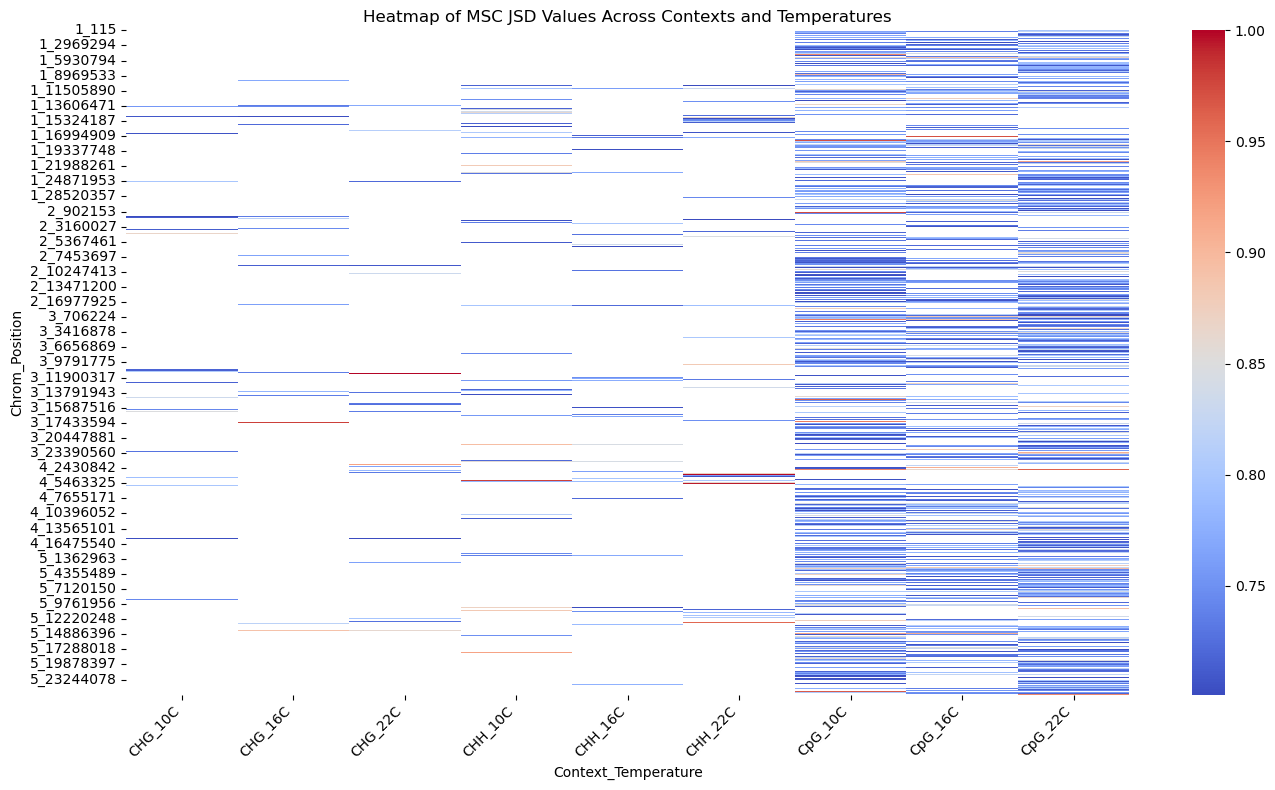

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_heatmap_data(filtered_data):
    heatmap_data = []
    for temp in filtered_data:
        for context in filtered_data[temp]:
            df = filtered_data[temp][context]
            if not df.empty:
                df['context_temp'] = f'{context}_{temp}'
                heatmap_data.append(df[['chrom', 'start', 'end', 'JSD_bit_', 'context_temp']])
    
    combined_df = pd.concat(heatmap_data)
    
    combined_df = combined_df.sort_values(by=['chrom', 'start', 'end'])
    
    heatmap_df = combined_df.pivot_table(index=['chrom', 'start', 'end'], columns='context_temp', values='JSD_bit_')
    
    heatmap_df.index = [f'{chrom}_{start}' for chrom, start, end in heatmap_df.index]
    
    return heatmap_df

def plot_jsd_heatmap(heatmap_df):
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_df, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
    
    plt.title("Heatmap of MSC JSD Values Across Contexts and Temperatures")
    plt.xlabel("Context_Temperature")
    plt.ylabel("Chrom_Position")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("Corr_heatmap_all", dpi=300)
    plt.show()

heatmap_df = prepare_heatmap_data(filtered_data)

plot_jsd_heatmap(heatmap_df)


/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

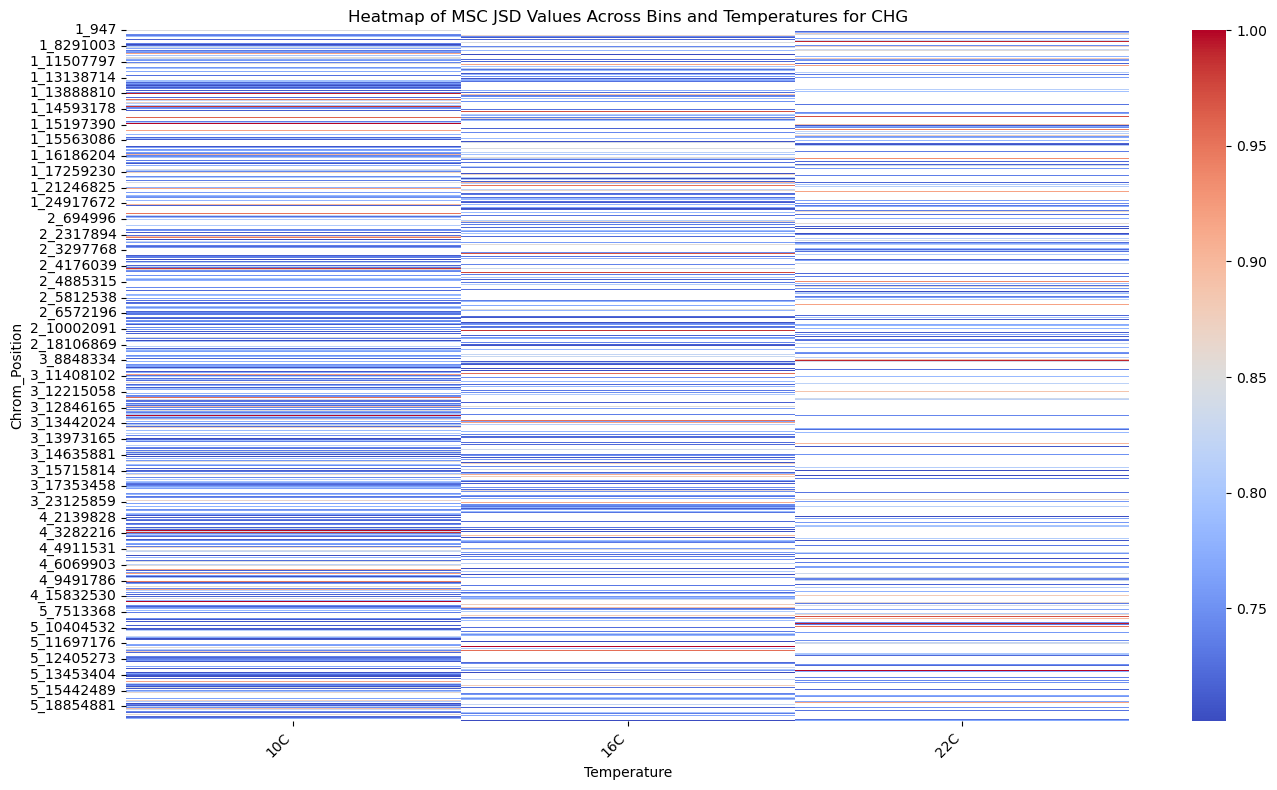

/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

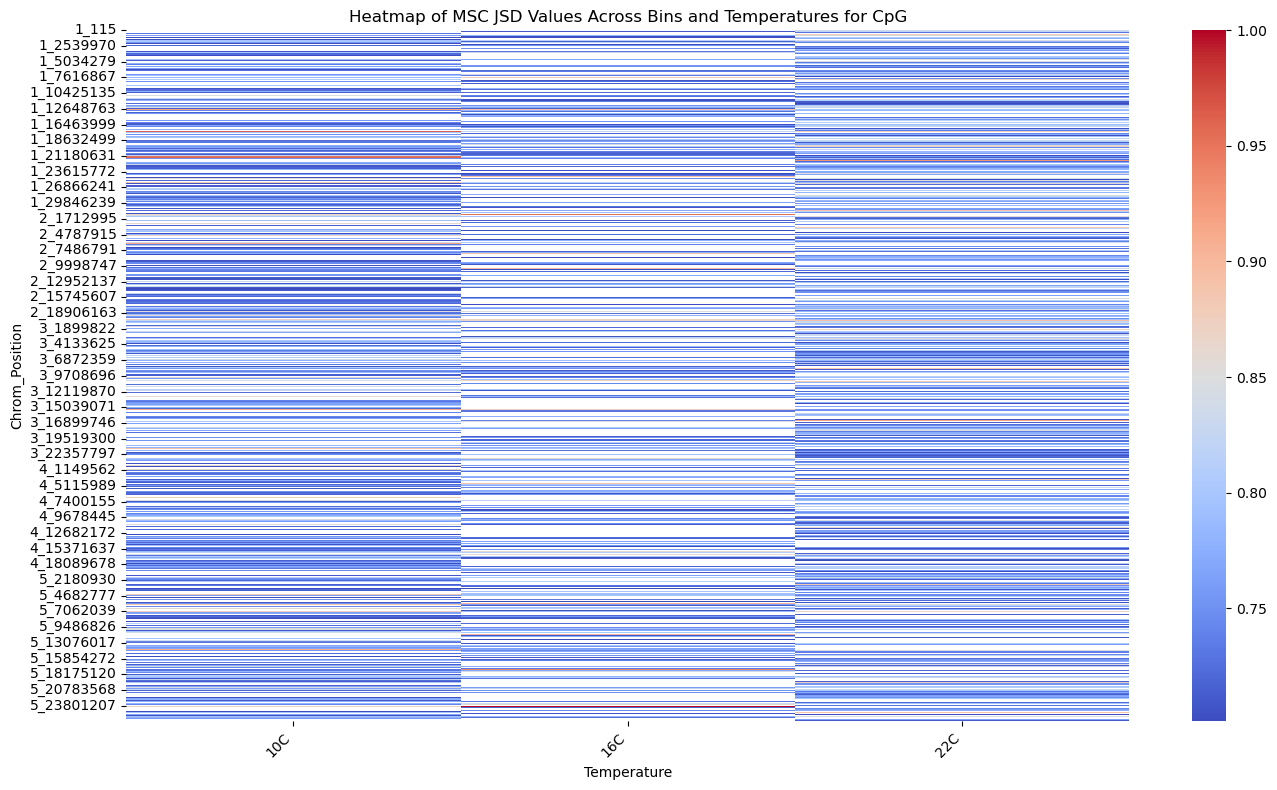

/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = temp
/sctmp/eharpu/ipykernel_1491751/4178613484.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

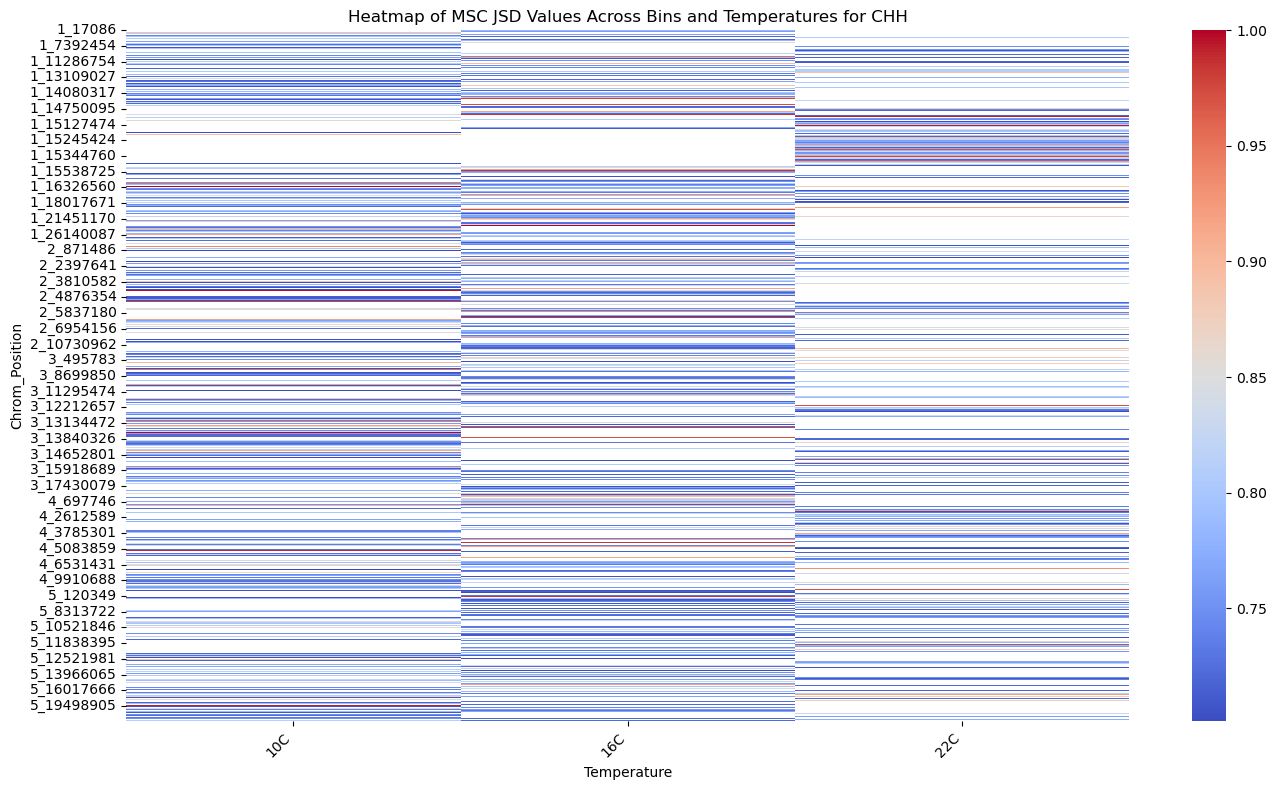

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_heatmap_data_for_context(filtered_data, context):
    heatmap_data = []

    for temp in filtered_data:
        if context in filtered_data[temp]:
            df = filtered_data[temp][context]
            
            if not df.empty:
                df['temp'] = temp
                heatmap_data.append(df[['chrom', 'start', 'end', 'JSD_bit_', 'temp']])
    
    combined_df = pd.concat(heatmap_data)
    
    combined_df = combined_df.sort_values(by=['chrom', 'start', 'end'])
    
    heatmap_df = combined_df.pivot_table(index=['chrom', 'start', 'end'], columns='temp', values='JSD_bit_')
    
    heatmap_df.index = [f'{chrom}_{start}' for chrom, start, end in heatmap_df.index]
    
    return heatmap_df

def plot_jsd_heatmap_for_context(heatmap_df, context):
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_df, cmap="coolwarm", annot=False, fmt=".2f", cbar=True)
    
    plt.title(f"Heatmap of MSC JSD Values Across Bins and Temperatures for {context}")
    plt.xlabel("Temperature")
    plt.ylabel("Chrom_Position")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    plt.show()

contexts = ['CHG', 'CpG', 'CHH']

for context in contexts:
    heatmap_df = prepare_heatmap_data_for_context(filtered_data, context)
    plot_jsd_heatmap_for_context(heatmap_df, context)


/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/seaborn/_oldcore.py

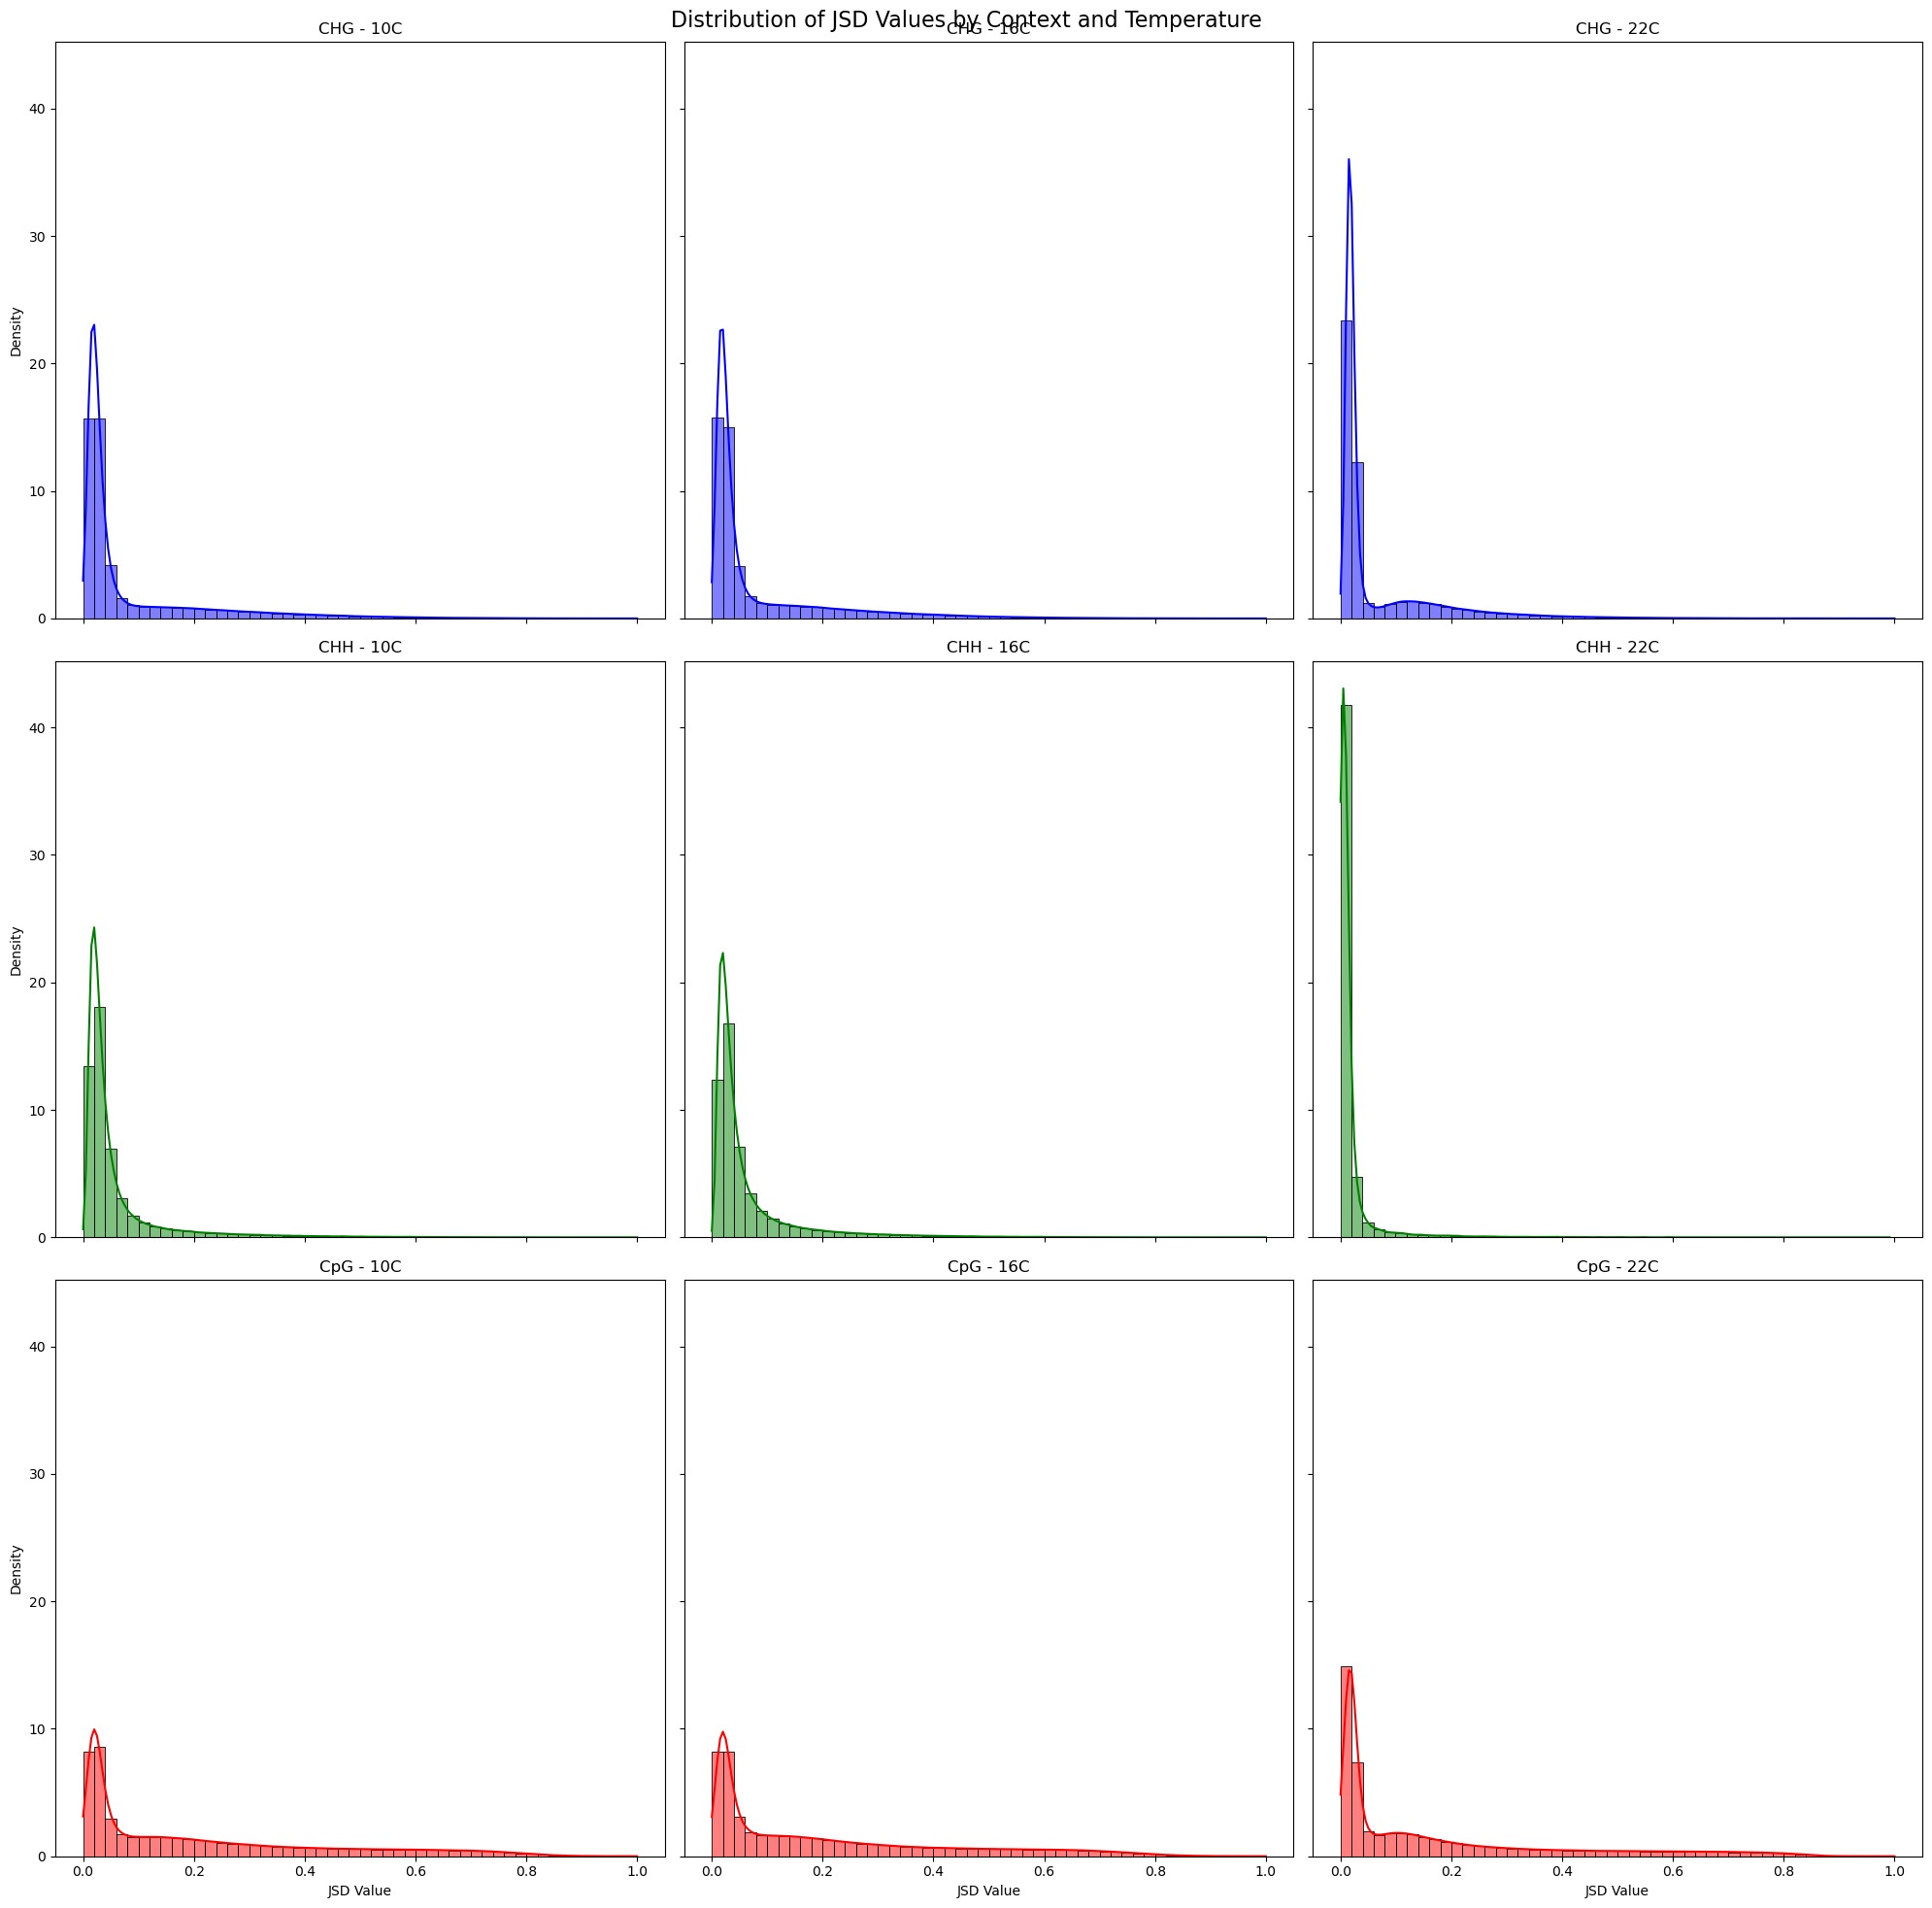

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Create a new column combining context and temperature
df['context_temp'] = df['context'] + '_' + df['temperature']

# Set up the plot
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)
fig.suptitle('Distribution of JSD Values by Context and Temperature', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Define colors for each context
color_dict = {'CHG': 'blue', 'CHH': 'green', 'CpG': 'red'}

# Create a histogram for each context_temp combination
for i, (context_temp, group) in enumerate(df.groupby('context_temp')):
    context, temp = context_temp.split('_')
    ax = axes[i]
    
    # Create the histogram
    sns.histplot(data=group, x='JSD_bit_', kde=True, ax=ax, color=color_dict[context], bins=50, stat='density')
    
    # Set the title and labels
    ax.set_title(f'{context} - {temp}')
    ax.set_xlabel('JSD Value')
    ax.set_ylabel('Density')

# Adjust the layout and display the plot
plt.tight_layout()
plt.savefig('jsd_distribution.png', dpi=300, bbox_inches='tight')

plt.show()



/home/eharpu/data/conda/envs/environment_shannon/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


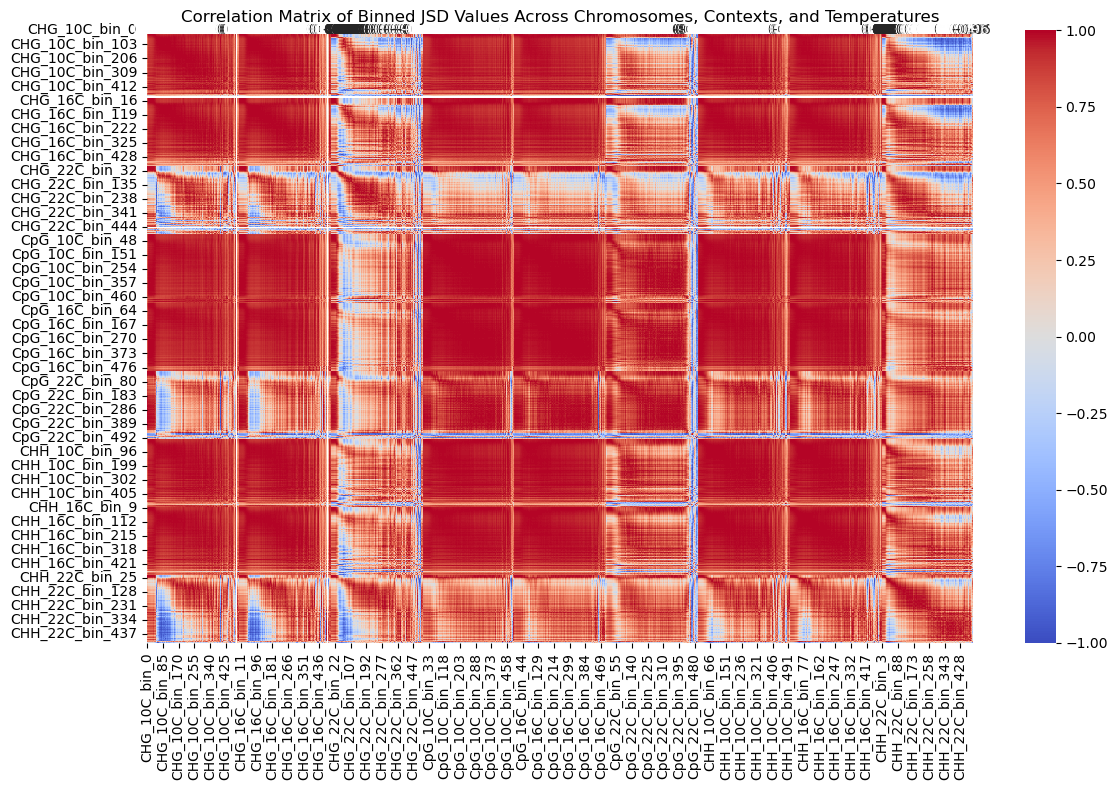

In [6]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import numpy as np

def load_data(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                header_line = line[1:].strip()  # Remove '#' and strip spaces
                columns = header_line.split('\t')  # Split the header by tab
                break
        else:
            raise ValueError(f"No header line found in {file_path}")
    
    # Read the data into a DataFrame
    df = pd.read_csv(file_path, sep='\t', header=None, names=columns, comment='#')
    
    # Ensure required columns are present
    if 'JSD_bit_' not in df.columns:
        raise ValueError(f"'JSD_bit_' column not found in {file_path}")

    return df

def process_file(file_path, bin_edges):
    chrom_name = os.path.basename(file_path).split('.')[0]
    
    df = load_data(file_path)
    binned_data, _ = np.histogram(df['JSD_bit_'], bins=bin_edges)
    
    return chrom_name, binned_data

def process_directory_parallel(directory, context, temperature, bin_edges):
    dir_path = os.path.join(base_path, directory)
    file_paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
    
    with ProcessPoolExecutor(max_workers=30) as executor:
        results = list(executor.map(process_file, file_paths, [bin_edges]*len(file_paths)))
    
    chrom_data = pd.DataFrame({chrom: bins for chrom, bins in results}).T
    chrom_data.columns = [f'{context}_{temperature}_bin_{i}' for i in range(len(bin_edges) - 1)]
    
    return chrom_data

def aggregate_jsd_values(base_path, contexts, temps, bin_edges):
    all_data = []
    
    for context in contexts:
        for temp in temps:
            directory = f"{context}_{temp}"
            context_data = process_directory_parallel(directory, context, temp, bin_edges)
            all_data.append(context_data)
    
    return pd.concat(all_data, axis=1)

def plot_correlation_matrix(data):
    corr_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    
    plt.title("Correlation Matrix of Binned JSD Values Across Chromosomes, Contexts, and Temperatures")
    plt.tight_layout()
    plt.show()

# Main script
base_path = "/shares/grossniklaus.botinst.uzh/eharputluoglu/tempResults"
contexts = ['CHG', 'CpG', 'CHH']
temps = ['10C', '16C', '22C']
bin_edges = np.linspace(0, 1, 500)  # Create 50 bins between 0 and 1

# Aggregate the binned JSD values for each chromosome, context, and temperature
data = aggregate_jsd_values(base_path, contexts, temps, bin_edges)

# Reorder chromosomes to be in a specific order
chromosome_order = ['chr_1', 'chr_2', 'chr_3', 'chr_4', 'chr_5', 'chr_Mt', 'chr_Pt']
data = data.reindex(chromosome_order)

# Plot the correlation matrix
plot_correlation_matrix(data)
